In [ ]:
import pandas as pd
import numpy as np
import ast
import re
import os
import nltk
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import RandomizedSearchCV,train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import tree

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings(action='ignore')
import seaborn as sn
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/sample_data/reviews.csv')
df.shape

(12495, 12)

In [ ]:
df.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo


In [ ]:
df['score'].value_counts()

5    2879
4    2775
1    2506
2    2344
3    1991
Name: score, dtype: int64

In [ ]:
df.isnull().sum()

reviewId                   0
userName                   0
userImage                  0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    2162
at                         0
replyContent            6677
repliedAt               6677
sortOrder                  0
appId                      0
dtype: int64

In [ ]:
use_df = df[['reviewId', 'userName','content', 'score']]
use_df.head()

,reviewId,userName,content,score
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,I cannot open the app anymore,1
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,I have been begging for a refund from this app...,1
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,Very costly for the premium version (approx In...,1
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,"Used to keep me organized, but all the 2020 UP...",1
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,Dan Birthday Oct 28,1


# Text Cleaning



In [ ]:
!pip install emot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 2.1 MB/s eta 0:00:00


In [ ]:
import re
import pickle
from emot.emo_unicode import UNICODE_EMOJI # For emojis
from emot.emo_unicode import EMOTICONS_EMO # For EMOTICONS
import random
from bs4 import BeautifulSoup

In [ ]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [ ]:
use_df['content'] = use_df['content'].apply(lambda x:remove_emoji(x))

In [ ]:
use_df['content'].head(2)

0                        I cannot open the app anymore
1    I have been begging for a refund from this app...
Name: content, dtype: object

In [ ]:
def cleantext(text):

    return re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)

use_df['content'] = use_df['content'].apply(lambda x:cleantext(x))
use_df.isnull().sum()

reviewId    0
userName    0
content     0
score       0
dtype: int64

In [ ]:
df_clean = use_df[(use_df['content']!=' ')&(use_df['content']!='')]
df_clean.shape,use_df.shape

((12446, 4), (12495, 4))

# Word Level Analysis

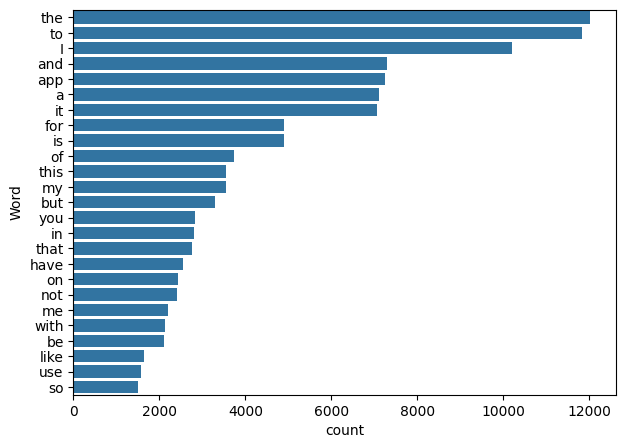

In [ ]:
def showmostfrequentwords(text,no_of_words):

    allwords = ' '.join([char for char in text])
    allwords = allwords.split()
    fdist = nltk.FreqDist(allwords)

    wordsdf = pd.DataFrame({'word':list(fdist.keys()),'count':list(fdist.values())})

    df = wordsdf.nlargest(columns="count",n = no_of_words)

    plt.figure(figsize=(7,5))
    ax = sn.barplot(data=df,x = 'count',y = 'word')
    ax.set(ylabel = 'Word')
    plt.show()

    return wordsdf

wordsdf = showmostfrequentwords(df_clean['content'],25)

# Removal of Stopwords

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# removing the stopwords

def removestopwords(text):

    removedstopword = [word for word in text.split() if word not in stop_words]
    return ' '.join(removedstopword)

df_clean['content'] = df_clean['content'].apply(lambda x:removestopwords(x))
df_clean['content'].iloc[1]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'I begging refund app month nobody replying'

# Lemmatizing the Text

In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemma=WordNetLemmatizer()

def lematizing(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = lemma.lemmatize(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence


df_clean['content'] = df_clean['content'].apply(lambda x: lematizing(x))
df_clean['content'].iloc[1]

[nltk_data] Downloading package wordnet to /root/nltk_data...


'I begging refund app month nobody replying'

# Stemming the Text

In [ ]:
# Approach

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stemming(sentence):

    stemmed_sentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemmed_sentence+=stem
        stemmed_sentence+=" "

    stemmed_sentence = stemmed_sentence.strip()
    return stemmed_sentence

df_clean['content'] = df_clean['content'].apply(lambda text:stemming(text))
df_clean['content'].iloc[1]

'i beg refund app month nobodi repli'

# Using Count-Vectorizer

In [ ]:
## count vectorizer

data = df_clean[['reviewId', 'content', 'score']]

count_vec = CountVectorizer(max_df=0.90,min_df=2,
                           max_features=1000,stop_words='english')

bagofword_vec = count_vec.fit_transform(data['content'])
bagofword_vec

<12446x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 123937 stored elements in Compressed Sparse Row format>

In [ ]:
test = df_clean['score']
X_train, X_test, y_train, y_test = train_test_split(bagofword_vec,test,
                                                    test_size=0.2)
X_train.shape,X_test.shape

((9956, 1000), (2490, 1000))

In [ ]:
mb = MultinomialNB()
mb.fit(X_train,y_train)
mbpred = mb.predict(X_test)
print(metrics.accuracy_score(y_test,mbpred))

0.4714859437751004


In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
print(metrics.accuracy_score(y_test,rf_pred))

0.42208835341365464


# Using TF-DIF

In [ ]:
#Labeling each 'genre' with an unique number

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data = df_clean[['reviewId', 'content', 'score']]

y=data['score']

X_train,X_test,y_train,y_test = train_test_split(df_clean['content']
                                                ,y,test_size=0.2,
                                                random_state=557)

X_train.shape,X_test.shape

((9956,), (2490,))

In [ ]:
#Performing tf-idf

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
xtrain_tfidf = tfidf_vectorizer.fit_transform(X_train.values.astype('U'))
xtest_tfidf = tfidf_vectorizer.transform(X_test.values.astype('U'))

In [ ]:
dtree = DecisionTreeClassifier()
dtree.fit(xtrain_tfidf,y_train)
dtree_pred = dtree.predict(xtest_tfidf)
metrics.accuracy_score(y_test,dtree_pred)

0.3582329317269076

In [ ]:
rf = RandomForestClassifier()
rf.fit(xtrain_tfidf,y_train)
rf_pred = rf.predict(xtest_tfidf)
metrics.accuracy_score(y_test,rf_pred)

0.44176706827309237

In [ ]:
lr = LogisticRegression()
lr.fit(xtrain_tfidf,y_train)
lr_pred = lr.predict(xtest_tfidf)
metrics.accuracy_score(y_test,lr_pred)

0.46546184738955826

# Using TF-DIF X NFM



In [ ]:
text = list(df_clean['content'])
print(len(text))

12446


In [ ]:
vec = TfidfVectorizer()
tfd = vec.fit_transform(text)

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
num_topics = 5
nmf = NMF(n_components=num_topics, random_state=50, max_iter=500)

In [ ]:
W1 = nmf.fit_transform(tfd)
H1 = nmf.components_

In [ ]:
df_new = pd.DataFrame({'text':text, 'label':[np.argmax(i) for i in W1]})
df_new

,text,label
0,i cannot open app anymor,0
1,i beg refund app month nobodi repli,0
2,veri costli premium version approx indian rupe...,4
3,use keep organ 2020 updat made mess thing y cu...,0
4,dan birthday oct 28,0
...,...,...
12441,ok but undestad repeat task shedul,0
12442,i realli like planner help achiev task goal av...,0
12443,veri use app you must tri,4
12444,would pay even addit updat absolut love wish w...,0


from matplotlib import pyplot as plt
df_new['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_new['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
train,test = train_test_split(df_new, train_size=0.7, random_state=25, stratify=df_new.label)

X_train = train.text
y_train = train.label

X_test = test.text
y_test = test.label

In [ ]:
vec = TfidfVectorizer()
X_train_tfidf = vec.fit_transform(X_train)
X_test_tfidf = vec.transform(X_test)

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train_tfidf,y_train)
dt_pred = dt.predict(X_test_tfidf)
print(metrics.classification_report(y_test,dt_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2524
           1       0.92      0.90      0.91       320
           2       0.89      0.90      0.89       278
           3       0.91      0.95      0.93       150
           4       0.82      0.81      0.81       462

    accuracy                           0.92      3734
   macro avg       0.90      0.90      0.90      3734
weighted avg       0.92      0.92      0.92      3734



In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
rf_pred = rf.predict(X_test_tfidf)
print(metrics.classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2524
           1       0.98      0.82      0.89       320
           2       0.98      0.79      0.87       278
           3       0.96      0.81      0.88       150
           4       0.96      0.71      0.82       462

    accuracy                           0.92      3734
   macro avg       0.96      0.83      0.88      3734
weighted avg       0.93      0.92      0.92      3734

